In [2]:
import pandas as pd
import numpy as np

In [3]:
#load csv file
def load_data(file_index):
    df=pd.read_csv(f'./scratch/{file_index}.csv')
    A=np.array(df,dtype=complex)
    return A

In [4]:
def circular_moving_average(signals, hw):
        """循环移动平均，hw为半宽"""
        n_sig = signals.shape[1]
        smoothed = np.zeros_like(signals)
        
        for i in range(n_sig):
            # 循环索引：i-hw 到 i+hw
            indices = np.arange(i - hw, i + hw + 1) % n_sig
            smoothed[:,i] = np.mean(signals[:, indices], axis=1)
        
        return smoothed
def whole_pipeline(rd_data:np.ndarray):
    #perform dft on doppler axis
    n = rd_data.shape[1]
    dft_data = np.fft.fft(rd_data, axis=1)
    #compute spectral energy
    spectral_energy = np.abs(dft_data) ** 2/n
    #perform moving average for each range bin
    hw=int(np.round(n**0.8 / (4 * np.pi)))
    smoothed_energy = circular_moving_average(spectral_energy, hw=hw)
    epsilon=1e-10
    Lx = np.log(np.maximum(smoothed_energy, epsilon))
    return Lx

In [5]:
def coherent(array,n_pulse=256):
    n=array.shape[0]
    num_period=(int)(n/n_pulse)
    all_Ls=[]
    for i in range(num_period):
        A= array[i*n_pulse:(i+1)*n_pulse]
        A=A.transpose()
        Lx = whole_pipeline(A)
        all_Ls.append(Lx)
    conc=np.concatenate(all_Ls, axis=0)
    return conc

In [6]:
A=load_data(31)
conc=coherent(A)
norms=np.linalg.norm((conc-np.mean(conc,axis=0)),axis=1)
for i in range(14):
    indices=[i+14*k for k in range((int)(conc.shape[0]/14))]
    print(np.mean(norms[indices]))

16.15304837942423
15.196370352064609
17.19714981309681
23.156898242058123
24.68834045650597
24.368649015186193
23.0075179485267
18.790026611973826
14.547423621723304
14.491639023535166
15.03097511328491
15.16205896692164
15.57486551940082
15.943007502612351


In [20]:
from sklearn.decomposition import PCA
pca=PCA(n_components=2)
v1=pca.fit_transform(conc)
# for i in range(14):
#     indices=[i+14*k for k in range((int)(conc.shape[0]/14))]
#     print(np.mean(v1[indices]))

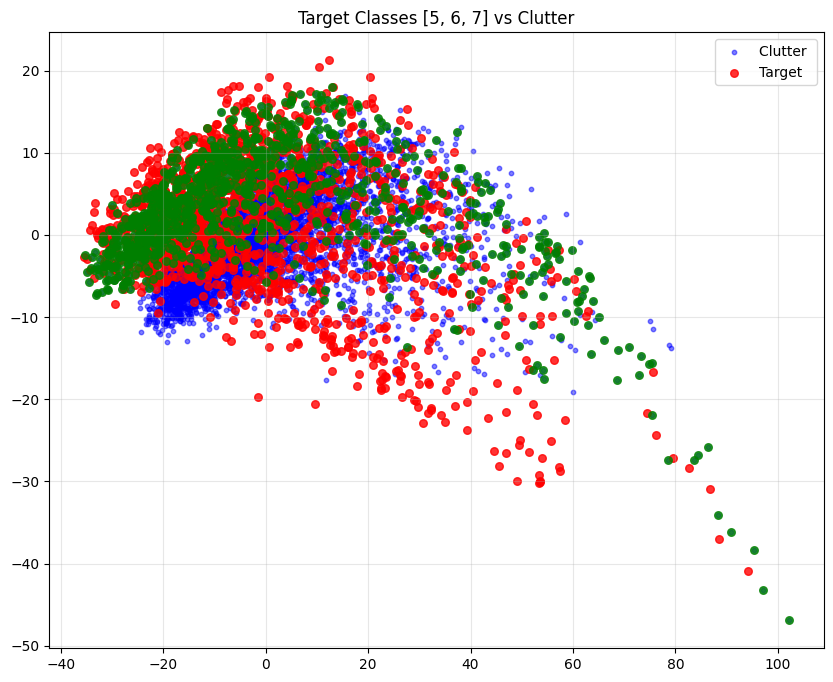

In [21]:
# Simple version to get started
import numpy as np
import umap
import matplotlib.pyplot as plt

# Your data
vectors = conc  # shape (7154, 256)

# Define which mod classes are targets
target_classes = [5,6,7]  # Change to your actual target classes
observation_class=[3,4]
# Create binary labels
labels = np.arange(7154) % 14
binary_labels = np.isin(labels, target_classes).astype(int)

# Run UMAP
# reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.05)
# embedding = reducer.fit_transform(vectors)
embedding=v1
# Simple plot
#plot target, observation and clutter on three different plots

plt.figure(figsize=(10, 8))
#first figure
# plt.subplot(1, 2, 1)
plt.scatter(embedding[binary_labels == 0, 0], embedding[binary_labels == 0, 1], 
            c='blue', s=10, alpha=0.5, label='Clutter ')
# plt.legend()
# plt.subplot(1, 2, 2)
plt.scatter(embedding[binary_labels == 1, 0], embedding[binary_labels == 1, 1], 
            c='red', s=30, alpha=0.8, label='Target ')
plt.legend()
# # plt.subplot(1, 3, 3)
plt.scatter(embedding[np.isin(labels, observation_class), 0], embedding[np.isin(labels, observation_class), 1],
            c='green', s=30, alpha=0.8, label='Observation ')

# plt.legend()
plt.title(f'Target Classes {target_classes} vs Clutter')
plt.grid(alpha=0.3)
plt.show()

In [28]:
def optimize_target_separation(vectors, target_classes):
    """
    Try different techniques to maximize target/clutter separation.
    """
    labels = np.arange(len(vectors)) % 14
    binary_labels = np.isin(labels, target_classes).astype(int)
    
    scaler = StandardScaler()
    vectors_norm = scaler.fit_transform(vectors)
    
    # Try different UMAP configurations
    configurations = [
        {'n_neighbors': 10, 'min_dist': 0.01, 'metric': 'euclidean', 'name': 'Local Focus'},
        {'n_neighbors': 30, 'min_dist': 0.1, 'metric': 'euclidean', 'name': 'Balanced'},
        {'n_neighbors': 50, 'min_dist': 0.5, 'metric': 'euclidean', 'name': 'Global Focus'},
        {'n_neighbors': 15, 'min_dist': 0.05, 'metric': 'cosine', 'name': 'Cosine Metric'},
    ]
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    axes = axes.flatten()
    
    best_score = -1
    best_embedding = None
    best_config = None
    
    for ax, config in zip(axes, configurations):
        reducer = umap.UMAP(
            n_components=2,
            n_neighbors=config['n_neighbors'],
            min_dist=config['min_dist'],
            metric=config['metric'],
            random_state=42
        )
        
        embedding = reducer.fit_transform(vectors_norm)
        
        # Color: red for targets, blue for clutter
        colors = ['blue' if label == 0 else 'red' for label in binary_labels]
        
        ax.scatter(
            embedding[:, 0], embedding[:, 1],
            c=colors,
            s=10,
            alpha=0.7
        )
        
        # Calculate silhouette score
        from sklearn.metrics import silhouette_score
        score = silhouette_score(embedding, binary_labels)
        
        ax.set_title(f"{config['name']}\nSilhouette: {score:.3f}", fontsize=11)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.grid(alpha=0.2)
        
        # Track best configuration
        if score > best_score:
            best_score = score
            best_embedding = embedding
            best_config = config
    
    plt.suptitle('UMAP Configurations for Target/Clutter Separation', fontsize=14)
    plt.tight_layout()
    
    print(f"\n=== Best Configuration ===")
    print(f"Name: {best_config['name']}")
    print(f"Silhouette Score: {best_score:.4f}")
    print(f"Parameters: n_neighbors={best_config['n_neighbors']}, "
          f"min_dist={best_config['min_dist']}, metric={best_config['metric']}")
    
    return best_embedding, best_config

best_embedding,best_config = optimize_target_separation(conc, target_classes=[5,6,7])

NameError: name 'StandardScaler' is not defined

In [ ]:
def quick_target_decision(data):
    """
    Quick decision: Which range bins have targets?
    Returns a simple answer for your 14 range bins
    """
    # Simple method: Compare each bin to average of others
    mean_power = np.mean(np.abs(data) ** 2, axis=0)
    
    target_decisions = []
    for i in range(14):
        # Compare bin i to average of all other bins
        other_bins = np.delete(mean_power, i)
        ratio = mean_power[i] / np.mean(other_bins)
        
        # Decision threshold (adjust based on your data)
        if ratio > 1.1:  # 3 dB higher than average
            target_decisions.append(True)
        else:
            target_decisions.append(False)
    
    target_bins = [i for i, decision in enumerate(target_decisions) if decision]
    
    return target_bins, target_decisions, mean_power

# One-line answer:
target_bins, decisions, powers = quick_target_decision(A)
print(f"Targets in range bins: {target_bins}")

Targets in range bins: [3, 4, 5, 6, 7]


In [145]:
import numpy as np
import matplotlib.pyplot as plt

def cfar_1d_range(power_profile, guard_cells=1, training_cells=3, pfa=1e-6, mode='CA'):
    """
    1D CFAR in range dimension only
    
    Parameters:
    - power_profile: 1D array of power values for each range bin (length 14)
    - guard_cells: Number of guard cells on each side of CUT
    - training_cells: Number of training cells on each side of guard region
    - pfa: Probability of false alarm
    - mode: 'CA' (Cell-Averaging), 'OS' (Ordered-Statistic), 'GO' (Greatest-Of)
    
    Returns:
    - detections: Boolean array indicating which range bins have targets
    - thresholds: Calculated threshold for each range bin
    """
    num_bins = len(power_profile)
    detections = np.zeros(num_bins, dtype=bool)
    thresholds = np.zeros(num_bins)
    
    # Validate parameters for small array
    if 2 * (guard_cells + training_cells) >= num_bins:
        raise ValueError("Too many guard/training cells for only 14 range bins!")
    
    # Calculate threshold multiplier (alpha)
    if mode == 'CA':  # Cell-Averaging CFAR
        alpha = training_cells * (pfa ** (-1.0 / (2 * training_cells)) - 1)
    elif mode == 'OS':  # Ordered-Statistic (k-th largest)
        k = int(0.75 * 2 * training_cells)  # Typically 75% of training cells
        alpha = k * (pfa ** (-1.0 / k) - 1)
    elif mode == 'GO':  # Greatest-Of CFAR
        alpha = training_cells * (pfa ** (-1.0 / training_cells) - 1)
    
    # Process each range bin as Cell Under Test (CUT)
    for cut_idx in range(num_bins):
        # Skip edges if you want, or handle specially
        left_start = max(0, cut_idx - guard_cells - training_cells)
        left_end = max(0, cut_idx - guard_cells)
        
        right_start = min(num_bins, cut_idx + guard_cells + 1)
        right_end = min(num_bins, cut_idx + guard_cells + training_cells + 1)
        
        # Collect training cells
        training_cells_left = power_profile[left_start:left_end]
        training_cells_right = power_profile[right_start:right_end]
        
        all_training = np.concatenate([training_cells_left, training_cells_right])
        
        if len(all_training) == 0:
            # Edge case - use global noise estimate
            noise_estimate = np.mean(power_profile)
        else:
            if mode == 'CA':
                noise_estimate = np.mean(all_training)
            elif mode == 'OS':
                noise_estimate = np.sort(all_training)[-1]  # Largest value
            elif mode == 'GO':
                left_mean = np.mean(training_cells_left) if len(training_cells_left) > 0 else 0
                right_mean = np.mean(training_cells_right) if len(training_cells_right) > 0 else 0
                noise_estimate = max(left_mean, right_mean)
        
        # Calculate threshold
        threshold = alpha * noise_estimate
        thresholds[cut_idx] = threshold
        
        # Check detection
        if power_profile[cut_idx] > threshold:
            detections[cut_idx] = True
    
    return detections, thresholds

In [146]:
def detect_targets_all_pulses(data, method='pulse_by_pulse', **cfar_params):
    """
    Detect targets across all 130,171 pulses
    
    Parameters:
    - data: Complex data [130171 pulses × 14 range_bins]
    - method: 'pulse_by_pulse', 'doppler_processed', or 'power_summed'
    - cfar_params: Parameters for 1D CFAR
    
    Returns:
    - detection_matrix: Boolean matrix [pulses × range_bins]
    - range_detection_stats: Statistics for each range bin
    """
    num_pulses, num_range_bins = data.shape
    
    if method == 'pulse_by_pulse':
        # Apply CFAR to each pulse independently
        detection_matrix = np.zeros((num_pulses, num_range_bins), dtype=bool)
        
        for pulse_idx in range(num_pulses):
            power_profile = np.abs(data[pulse_idx, :]) ** 2
            detections, _ = cfar_1d_range(power_profile, **cfar_params)
            detection_matrix[pulse_idx, :] = detections
    
    elif method == 'power_summed':
        # Sum power across pulses, then apply CFAR
        power_summed = np.sum(np.abs(data) ** 2, axis=0)
        range_detections, _ = cfar_1d_range(power_summed, **cfar_params)
        
        # Create matrix (same detection for all pulses at detected range bins)
        detection_matrix = np.zeros((num_pulses, num_range_bins), dtype=bool)
        for bin_idx in range(num_range_bins):
            if range_detections[bin_idx]:
                detection_matrix[:, bin_idx] = True
    
    elif method == 'doppler_processed':
        # Process in CPI blocks with Doppler processing
        cpi_length = 256
        num_cpis = num_pulses // cpi_length
        detection_matrix = np.zeros((num_pulses, num_range_bins), dtype=bool)
        
        for cpi_idx in range(num_cpis):
            start_idx = cpi_idx * cpi_length
            end_idx = start_idx + cpi_length
            cpi_data = data[start_idx:end_idx, :]
            
            # Doppler processing (FFT across pulses)
            doppler_data = np.fft.fft(cpi_data, axis=0)
            doppler_power = np.abs(doppler_data) ** 2
            
            # Sum across Doppler bins (integrated power)
            integrated_power = np.sum(doppler_power, axis=0)
            
            # Apply CFAR
            detections, _ = cfar_1d_range(integrated_power, **cfar_params)
            
            # Mark all pulses in this CPI for detected range bins
            for bin_idx in range(num_range_bins):
                if detections[bin_idx]:
                    detection_matrix[start_idx:end_idx, bin_idx] = True
    
    # Calculate statistics
    range_detection_stats = {
        'detection_count': np.sum(detection_matrix, axis=0),
        'detection_percentage': 100 * np.sum(detection_matrix, axis=0) / num_pulses,
        'most_detected_bin': int(np.argmax(np.sum(detection_matrix, axis=0))),
        'least_detected_bin': int(np.argmin(np.sum(detection_matrix, axis=0)))
    }
    
    return detection_matrix, range_detection_stats

In [147]:
def adaptive_cfar_1d(power_profile, pfa=1e-6):
    """
    Adaptive CFAR that handles edges properly for small arrays
    
    For 14 range bins, we need special edge handling
    """
    num_bins = len(power_profile)
    detections = np.zeros(num_bins, dtype=bool)
    thresholds = np.zeros(num_bins)
    
    # For each cell under test
    for cut_idx in range(num_bins):
        # Adaptive training cell selection based on position
        if cut_idx == 0:  # First bin
            training_cells = power_profile[2:5]  # Use bins 2-4
        elif cut_idx == 1:  # Second bin
            training_cells = np.concatenate([power_profile[0:1], power_profile[3:6]])
        elif cut_idx == num_bins - 1:  # Last bin
            training_cells = power_profile[-5:-2]  # Use bins 9-11
        elif cut_idx == num_bins - 2:  # Second last bin
            training_cells = np.concatenate([power_profile[-6:-3], power_profile[-1:]])
        else:  # Middle bins
            training_cells = np.concatenate([
                power_profile[cut_idx-3:cut_idx-1],  # Left side
                power_profile[cut_idx+2:cut_idx+4]   # Right side
            ])
        
        # Calculate noise estimate (trimmed mean to avoid target contamination)
        sorted_cells = np.sort(training_cells)
        trimmed_cells = sorted_cells[1:-1]  # Remove min and max
        noise_estimate = np.mean(trimmed_cells)
        
        # Calculate threshold (adaptive alpha based on number of training cells)
        num_train = len(trimmed_cells)
        alpha = num_train * (pfa ** (-1.0 / num_train) - 1)
        threshold = alpha * noise_estimate
        thresholds[cut_idx] = threshold
        
        # Detection
        if power_profile[cut_idx] > threshold:
            detections[cut_idx] = True
    
    return detections, thresholds

In [150]:
def identify_target_range_bins(data, consistency_threshold=0.1):
    """
    Identify which range bins consistently show targets
    
    Parameters:
    - data: Original data [pulses × range_bins]
    - consistency_threshold: Percentage of pulses that must show detection
    
    Returns:
    - target_bins: List of range bins with consistent targets
    - confidence_scores: Confidence for each range bin
    """
    num_pulses, num_range_bins = data.shape
    
    # Method 1: Simple power-based detection
    mean_power = np.mean(np.abs(data) ** 2, axis=0)
    std_power = np.std(np.abs(data) ** 2, axis=0)
    
    # Calculate SNR-like metric for each range bin
    snr_metric = (mean_power - np.min(mean_power)) / (std_power + 1e-10)
    
    # Method 2: CFAR-based consistency
    cfar_params = {
        'guard_cells': 1,
        'training_cells': 3,
        'pfa': 1e-4,
        'mode': 'CA'
    }
    
    detection_matrix, stats = detect_targets_all_pulses(
        data, 
        method='pulse_by_pulse', 
        **cfar_params
    )
    
    # Calculate detection consistency
    detection_consistency = stats['detection_percentage'] / 100  # Convert to 0-1
    
    # Combined confidence score
    confidence_scores = 0.7 * detection_consistency + 0.3 * (snr_metric / np.max(snr_metric))
    
    # Identify target bins
    target_bins = []
    for bin_idx in range(num_range_bins):
        if (detection_consistency[bin_idx] > consistency_threshold and 
            confidence_scores[bin_idx] > 0.5):
            target_bins.append(bin_idx)
    
    # If no bins meet threshold, take top 3
    if len(target_bins) == 0:
        top_indices = np.argsort(confidence_scores)[-3:]
        target_bins = sorted(top_indices.tolist())
    
    return target_bins, confidence_scores, detection_consistency

RANGE BIN TARGET ANALYSIS
Range Bin  0: Detection % =  15.66%, Confidence = 0.148 -> clutter
Range Bin  1: Detection % =  13.40%, Confidence = 0.109 -> clutter
Range Bin  2: Detection % =   5.25%, Confidence = 0.100 -> clutter
Range Bin  3: Detection % =   7.30%, Confidence = 0.213 -> clutter
Range Bin  4: Detection % =   6.93%, Confidence = 0.230 -> TARGET
Range Bin  5: Detection % =   6.58%, Confidence = 0.325 -> TARGET
Range Bin  6: Detection % =  18.22%, Confidence = 0.428 -> TARGET
Range Bin  7: Detection % =   4.62%, Confidence = 0.217 -> clutter
Range Bin  8: Detection % =   4.35%, Confidence = 0.030 -> clutter
Range Bin  9: Detection % =   6.43%, Confidence = 0.065 -> clutter
Range Bin 10: Detection % =   5.81%, Confidence = 0.081 -> clutter
Range Bin 11: Detection % =   6.71%, Confidence = 0.086 -> clutter
Range Bin 12: Detection % =  11.64%, Confidence = 0.105 -> clutter
Range Bin 13: Detection % =  11.64%, Confidence = 0.111 -> clutter

TARGET RANGE BINS: [4, 5, 6]
Total tar

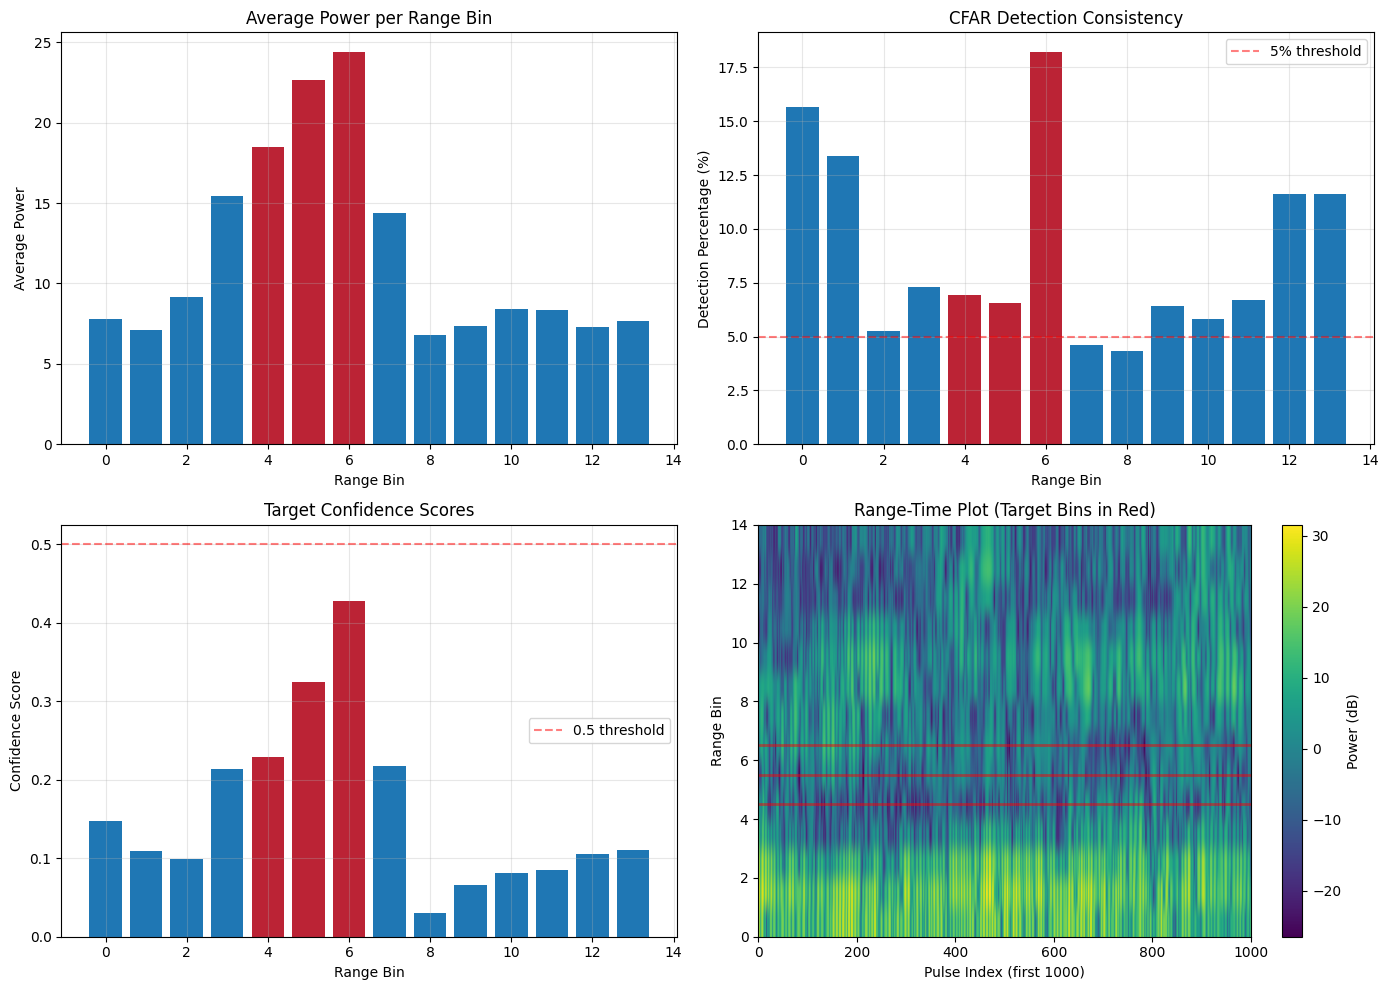


SUMMARY REPORT:
----------------------------------------
Most likely target bins: [4, 5, 6]
Range bin with highest detection %: 6 (18.2%)
Range bin with lowest detection %: 8 (4.4%)

Approximate target distances:
  Range bin 4: 60 meters
  Range bin 5: 75 meters
  Range bin 6: 90 meters


In [151]:
# Generate or load your data
# data = np.random.randn(130171, 14) + 1j * np.random.randn(130171, 14)

# Identify target range bins
target_bins, confidence_scores, detection_consistency = identify_target_range_bins(
    A, 
    consistency_threshold=0.05  # 5% detection consistency
)

print("="*60)
print("RANGE BIN TARGET ANALYSIS")
print("="*60)

for bin_idx in range(14):
    status = "TARGET" if bin_idx in target_bins else "clutter"
    print(f"Range Bin {bin_idx:2d}: "
          f"Detection % = {detection_consistency[bin_idx]*100:6.2f}%, "
          f"Confidence = {confidence_scores[bin_idx]:.3f} -> {status}")

print("\n" + "="*60)
print(f"TARGET RANGE BINS: {target_bins}")
print(f"Total target bins: {len(target_bins)}")
print("="*60)

# Visualize the results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Power profile averaged across all pulses
mean_power = np.mean(np.abs(A) ** 2, axis=0)
axes[0, 0].bar(range(14), mean_power)
axes[0, 0].set_xlabel('Range Bin')
axes[0, 0].set_ylabel('Average Power')
axes[0, 0].set_title('Average Power per Range Bin')
axes[0, 0].grid(True, alpha=0.3)
for bin_idx in target_bins:
    axes[0, 0].bar(bin_idx, mean_power[bin_idx], color='red', alpha=0.7)

# Plot 2: Detection consistency
axes[0, 1].bar(range(14), detection_consistency * 100)
axes[0, 1].axhline(y=5, color='r', linestyle='--', alpha=0.5, label='5% threshold')
axes[0, 1].set_xlabel('Range Bin')
axes[0, 1].set_ylabel('Detection Percentage (%)')
axes[0, 1].set_title('CFAR Detection Consistency')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
for bin_idx in target_bins:
    axes[0, 1].bar(bin_idx, detection_consistency[bin_idx] * 100, color='red', alpha=0.7)

# Plot 3: Confidence scores
axes[1, 0].bar(range(14), confidence_scores)
axes[1, 0].axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='0.5 threshold')
axes[1, 0].set_xlabel('Range Bin')
axes[1, 0].set_ylabel('Confidence Score')
axes[1, 0].set_title('Target Confidence Scores')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
for bin_idx in target_bins:
    axes[1, 0].bar(bin_idx, confidence_scores[bin_idx], color='red', alpha=0.7)

# Plot 4: Range-time plot highlighting target bins
power_db = 10 * np.log10(np.abs(A[:1000, :]) ** 2 + 1e-10)  # First 1000 pulses
im = axes[1, 1].imshow(power_db.T, aspect='auto', cmap='viridis', 
                       origin='lower', extent=[0, 1000, 0, 14])
for bin_idx in target_bins:
    axes[1, 1].axhline(y=bin_idx + 0.5, color='red', linestyle='-', alpha=0.5, linewidth=2)
axes[1, 1].set_xlabel('Pulse Index (first 1000)')
axes[1, 1].set_ylabel('Range Bin')
axes[1, 1].set_title('Range-Time Plot (Target Bins in Red)')
plt.colorbar(im, ax=axes[1, 1], label='Power (dB)')

plt.tight_layout()
plt.show()

# Generate summary report
print("\nSUMMARY REPORT:")
print("-" * 40)
print(f"Most likely target bins: {target_bins}")
print(f"Range bin with highest detection %: {np.argmax(detection_consistency)} "
      f"({detection_consistency[np.argmax(detection_consistency)]*100:.1f}%)")
print(f"Range bin with lowest detection %: {np.argmin(detection_consistency)} "
      f"({detection_consistency[np.argmin(detection_consistency)]*100:.1f}%)")

# If you know range resolution, convert bins to distances
# For example, if each bin = 15 meters:
range_resolution = 15  # meters (adjust based on your radar)
print(f"\nApproximate target distances:")
for bin_idx in target_bins:
    distance = bin_idx * range_resolution
    print(f"  Range bin {bin_idx}: {distance} meters")

In [124]:
import numpy as np
from scipy import signal

def cfar_2d_svi(data, guard_cells=2, training_cells=10, pfa=1e-6):
    """
    2D CFAR using Square Law Detector and Cell-Averaging (CA-CFAR)
    
    Parameters:
    - data: 2D array [pulses × range_bins]
    - guard_cells: Cells around CUT to exclude from averaging
    - training_cells: Cells to use for noise estimation
    - pfa: Probability of false alarm
    
    Returns:
    - detection_mask: Boolean array where True indicates target detection
    """
    num_pulses, num_range_bins = data.shape
    detection_mask = np.zeros_like(data, dtype=bool)
    
    # Convert to power domain (square law detector)
    power_data = np.abs(data) ** 2
    
    # Calculate threshold multiplier (alpha)
    alpha = training_cells * (pfa ** (-1.0 / training_cells) - 1)
    
    # Pad the data to handle edges
    pad_size = guard_cells + training_cells
    padded_data = np.pad(power_data, pad_size, mode='reflect')
    
    # Iterate through each cell under test (excluding padded regions)
    for i in range(pad_size, num_pulses + pad_size):
        for j in range(pad_size, num_range_bins + pad_size):
            # Define regions
            # Leading and lagging in range dimension
            range_train = []
            # Leading range cells
            if j - guard_cells - training_cells >= 0:
                range_train.append(padded_data[i, j - guard_cells - training_cells:j - guard_cells])
            # Lagging range cells
            if j + guard_cells + training_cells < padded_data.shape[1]:
                range_train.append(padded_data[i, j + guard_cells + 1:j + guard_cells + training_cells + 1])
            
            # Leading and lagging in pulse/Doppler dimension
            doppler_train = []
            # Leading pulse cells
            if i - guard_cells - training_cells >= 0:
                doppler_train.append(padded_data[i - guard_cells - training_cells:i - guard_cells, j])
            # Lagging pulse cells
            if i + guard_cells + training_cells < padded_data.shape[0]:
                doppler_train.append(padded_data[i + guard_cells + 1:i + guard_cells + training_cells + 1, j])
            
            # Combine all training cells
            if range_train or doppler_train:
                all_train = np.concatenate([arr.flatten() for arr in range_train + doppler_train])
                if len(all_train) > 0:
                    # Estimate noise level
                    noise_estimate = np.mean(all_train)
                    # Calculate threshold
                    threshold = alpha * noise_estimate
                    # Check detection
                    if padded_data[i, j] > threshold:
                        detection_mask[i - pad_size, j - pad_size] = True
    
    return detection_mask

def process_by_cpi(data, cpi_length=256, cfar_params=None):
    """
    Process data in CPI blocks
    
    Parameters:
    - data: Original data [130171 pulses × 14 range_bins]
    - cpi_length: Length of each CPI (256)
    - cfar_params: Dictionary of CFAR parameters
    
    Returns:
    - all_detections: List of detection masks for each CPI
    - processed_data: Array of processed data (optional)
    """
    if cfar_params is None:
        cfar_params = {
            'guard_cells': 2,
            'training_cells': 8,
            'pfa': 0.0001
        }
    
    num_pulses, num_range_bins = data.shape
    num_cpis = num_pulses // cpi_length
    
    all_detections = []
    
    for cpi_idx in range(num_cpis):
        # Extract CPI block
        start_idx = cpi_idx * cpi_length
        end_idx = start_idx + cpi_length
        cpi_data = data[start_idx:end_idx, :]
        
        # Perform CFAR on this CPI
        detections = cfar_2d_svi(cpi_data, **cfar_params)
        all_detections.append(detections)
        
        # Optional: Apply Doppler processing here
        # cpi_range_doppler = np.fft.fft(cpi_data, axis=0)
    
    return all_detections

In [125]:
def extract_target_locations(all_detections, cpi_length=256):
    """
    Extract target locations from CFAR detection results
    
    Parameters:
    - all_detections: List of detection masks from each CPI
    - cpi_length: Number of pulses per CPI (256)
    
    Returns:
    - targets: List of dictionaries with target information
    - detection_matrix: Consolidated detection matrix
    """
    num_cpis = len(all_detections)
    num_range_bins = all_detections[0].shape[1]  # Should be 14
    
    # Initialize consolidated detection matrix
    detection_matrix = np.zeros((num_cpis * cpi_length, num_range_bins), dtype=bool)
    targets = []
    
    # Process each CPI
    for cpi_idx, det_mask in enumerate(all_detections):
        # Find where detections occurred in this CPI
        det_indices = np.argwhere(det_mask)  # Returns [pulse_in_cpi, range_bin] pairs
        
        # Convert to global pulse indices
        global_pulse_start = cpi_idx * cpi_length
        
        for pulse_in_cpi, range_bin in det_indices:
            global_pulse = global_pulse_start + pulse_in_cpi
            
            # Update consolidated matrix
            detection_matrix[global_pulse, range_bin] = True
            
            # Create target entry
            target_info = {
                'cpi_index': cpi_idx,
                'pulse_in_cpi': pulse_in_cpi,
                'global_pulse': global_pulse,
                'range_bin': range_bin,
                'detection_time': global_pulse,  # Could convert to actual time
                'cpi_center_time': global_pulse_start + cpi_length/2
            }
            targets.append(target_info)
    
    return targets, detection_matrix

In [126]:
def group_detections_into_tracks(detection_matrix, min_pulses=3, max_gap=5):
    """
    Group detections into potential target tracks
    
    Parameters:
    - detection_matrix: Boolean matrix of detections [pulses × range_bins]
    - min_pulses: Minimum consecutive detections to form a track
    - max_gap: Maximum allowed gap in pulses for track continuation
    
    Returns:
    - tracks: List of track dictionaries
    """
    num_pulses, num_range_bins = detection_matrix.shape
    tracks = []
    visited = np.zeros_like(detection_matrix, dtype=bool)
    
    for range_bin in range(num_range_bins):
        pulse = 0
        while pulse < num_pulses:
            if detection_matrix[pulse, range_bin] and not visited[pulse, range_bin]:
                # Start new track
                track_pulses = []
                current_pulse = pulse
                
                # Collect consecutive or closely spaced detections
                while current_pulse < num_pulses:
                    if detection_matrix[current_pulse, range_bin]:
                        track_pulses.append(current_pulse)
                        visited[current_pulse, range_bin] = True
                        current_pulse += 1
                    else:
                        # Check for small gaps
                        gap = 0
                        while (current_pulse + gap < num_pulses and 
                               gap <= max_gap and 
                               not detection_matrix[current_pulse + gap, range_bin]):
                            gap += 1
                        
                        if gap <= max_gap and current_pulse + gap < num_pulses:
                            # Fill the gap
                            for g in range(gap):
                                track_pulses.append(current_pulse + g)
                            current_pulse += gap
                        else:
                            break
                
                # If track is long enough, save it
                if len(track_pulses) >= min_pulses:
                    track_info = {
                        'range_bin': range_bin,
                        'pulses': track_pulses,
                        'start_pulse': min(track_pulses),
                        'end_pulse': max(track_pulses),
                        'duration': len(track_pulses),
                        'range_bin_center': range_bin,  # Could convert to actual range
                        'detection_count': len([p for p in track_pulses 
                                               if detection_matrix[p, range_bin]])
                    }
                    tracks.append(track_info)
                
                pulse = current_pulse
            else:
                pulse += 1
    
    return tracks

In [127]:
def analyze_cpi_targets(data, all_detections, cpi_length=256):
    """
    Analyze Doppler characteristics of targets in each CPI
    
    Parameters:
    - data: Original complex radar data [pulses × range_bins]
    - all_detections: CFAR detection masks for each CPI
    - cpi_length: Pulses per CPI (256)
    
    Returns:
    - target_doppler_info: List of target Doppler characteristics
    """
    target_doppler_info = []
    num_cpis = len(all_detections)
    
    for cpi_idx in range(num_cpis):
        # Extract CPI data
        start_pulse = cpi_idx * cpi_length
        end_pulse = start_pulse + cpi_length
        cpi_data = data[start_pulse:end_pulse, :]
        
        # Get Doppler spectrum via FFT
        doppler_spectrum = np.fft.fft(cpi_data, axis=0)
        doppler_power = np.abs(doppler_spectrum) ** 2
        
        # Get detections for this CPI
        det_mask = all_detections[cpi_idx]
        det_indices = np.argwhere(det_mask)
        
        for pulse_in_cpi, range_bin in det_indices:
            # Extract Doppler profile for this range bin
            doppler_profile = doppler_power[:, range_bin]
            
            # Find peak Doppler bin (convert to frequency/velocity)
            peak_doppler_bin = np.argmax(doppler_profile)
            
            # Convert to Doppler frequency (assuming PRF is known)
            # doppler_freq = (peak_doppler_bin - cpi_length/2) * (prf / cpi_length)
            
            target_info = {
                'cpi_index': cpi_idx,
                'global_pulse': start_pulse + pulse_in_cpi,
                'range_bin': range_bin,
                'pulse_in_cpi': pulse_in_cpi,
                'doppler_bin': peak_doppler_bin,
                'doppler_power': doppler_profile[peak_doppler_bin],
                'mean_power': np.mean(doppler_profile),
                'snr_db': 10 * np.log10(doppler_profile[peak_doppler_bin] / 
                                       np.mean(doppler_profile))
            }
            target_doppler_info.append(target_info)
    
    return target_doppler_info

In [128]:
def complete_target_analysis(data, all_detections, cpi_length=256):
    """
    Complete pipeline: Extract, group, and analyze targets
    
    Returns comprehensive target information
    """
    # 1. Extract basic target locations
    targets, detection_matrix = extract_target_locations(all_detections, cpi_length)
    
    # 2. Group into tracks
    tracks = group_detections_into_tracks(detection_matrix, min_pulses=5, max_gap=3)
    
    # 3. Analyze Doppler characteristics
    doppler_info = analyze_cpi_targets(data, all_detections, cpi_length)
    
    # 4. Consolidate information
    consolidated_targets = []
    
    # Match Doppler info with basic detections
    for target in targets:
        # Find matching Doppler info
        doppler_match = None
        for doppler in doppler_info:
            if (doppler['cpi_index'] == target['cpi_index'] and 
                doppler['range_bin'] == target['range_bin'] and
                doppler['pulse_in_cpi'] == target['pulse_in_cpi']):
                doppler_match = doppler
                break
        
        # Find if this target belongs to a track
        track_match = None
        for track in tracks:
            if (track['range_bin'] == target['range_bin'] and 
                target['global_pulse'] in track['pulses']):
                track_match = track
                break
        
        # Create consolidated target entry
        consolidated = {
            'location': {
                'global_pulse': target['global_pulse'],
                'range_bin': target['range_bin'],
                'cpi_index': target['cpi_index']
            },
            'doppler': doppler_match,
            'track_info': track_match,
            'detection_confidence': 1.0  # Could calculate based on SNR, persistence
        }
        consolidated_targets.append(consolidated)
    
    # 5. Statistical summary
    summary = {
        'total_detections': len(targets),
        'total_tracks': len(tracks),
        'detections_per_range': np.sum(detection_matrix, axis=0),
        'detections_per_cpi': [np.sum(det) for det in all_detections],
        'mean_track_length': np.mean([t['duration'] for t in tracks]) if tracks else 0,
        'range_bin_activity': {
            'most_active': int(np.argmax(np.sum(detection_matrix, axis=0))),
            'least_active': int(np.argmin(np.sum(detection_matrix, axis=0)))
        }
    }
    
    return consolidated_targets, summary, detection_matrix

In [129]:
import matplotlib.pyplot as plt

def plot_target_locations(detection_matrix, tracks=None, title="CFAR Target Detections"):
    """
    Plot target detections and tracks
    """
    num_pulses, num_range_bins = detection_matrix.shape
    
    plt.figure(figsize=(14, 8))
    
    # Create detection plot
    det_pulses, det_ranges = np.where(detection_matrix)
    plt.scatter(det_pulses, det_ranges, 
                c='red', s=20, marker='o', 
                alpha=0.6, label='Individual Detections')
    
    # Overlay tracks if available
    if tracks:
        for track in tracks:
            track_pulses = track['pulses']
            track_range = [track['range_bin']] * len(track_pulses)
            plt.plot(track_pulses, track_range, 
                    'b-', linewidth=2, alpha=0.7, 
                    label='Track' if track == tracks[0] else "")
    
    plt.xlabel('Pulse Index', fontsize=12)
    plt.ylabel('Range Bin', fontsize=12)
    plt.title(title, fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.colorbar(label='Detection Intensity')
    plt.tight_layout()
    plt.show()

def plot_range_time_intensity(data, detection_matrix):
    """
    Plot range-time intensity with detections overlaid
    """
    plt.figure(figsize=(14, 8))
    
    # Plot background power
    power_db = 10 * np.log10(np.abs(data) ** 2 + 1e-10)
    plt.imshow(power_db.T, aspect='auto', cmap='viridis',
               origin='lower', alpha=0.7,
               extent=[0, data.shape[0], 0, data.shape[1]])
    
    # Overlay detections
    det_pulses, det_ranges = np.where(detection_matrix)
    plt.scatter(det_pulses, det_ranges, 
                c='red', s=10, marker='x',
                alpha=0.9, label='CFAR Detections')
    
    plt.colorbar(label='Power (dB)')
    plt.xlabel('Pulse Index', fontsize=12)
    plt.ylabel('Range Bin', fontsize=12)
    plt.title('Range-Time Intensity with CFAR Detections', fontsize=14)
    plt.legend()
    plt.tight_layout()
    plt.show()

Total detections: 374
Number of tracks: 0
Detections per range bin: [88 46  0  0  0  0 44 63  0  0  0  0 45 88]
Average track length: 0.00 pulses

First 10 target detections:
Target 0: Pulse 801, Range Bin 7, CPI 3
Target 1: Pulse 5158, Range Bin 1, CPI 20
Target 2: Pulse 5915, Range Bin 7, CPI 23
Target 3: Pulse 6354, Range Bin 7, CPI 24
Target 4: Pulse 6912, Range Bin 7, CPI 27
Target 5: Pulse 6913, Range Bin 7, CPI 27
Target 6: Pulse 7518, Range Bin 13, CPI 29
Target 7: Pulse 7519, Range Bin 13, CPI 29
Target 8: Pulse 7537, Range Bin 13, CPI 29
Target 9: Pulse 7538, Range Bin 13, CPI 29


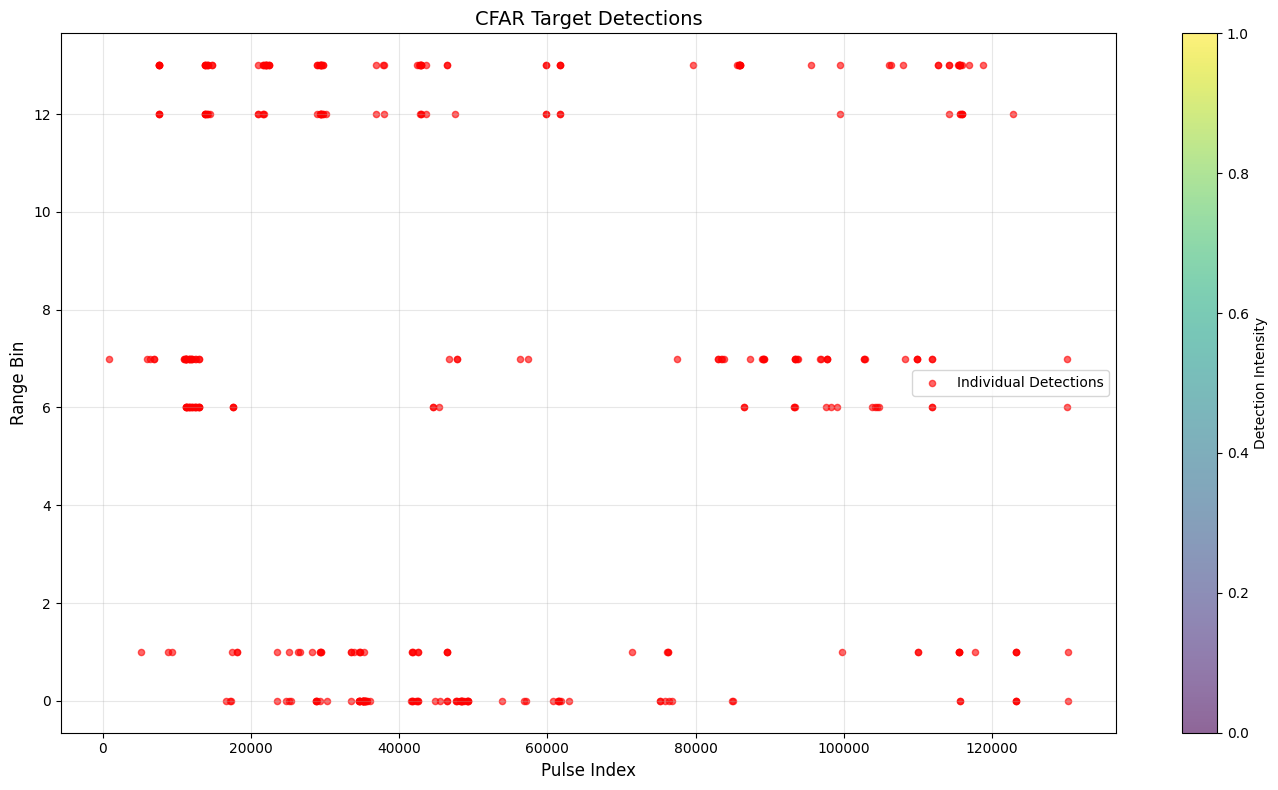

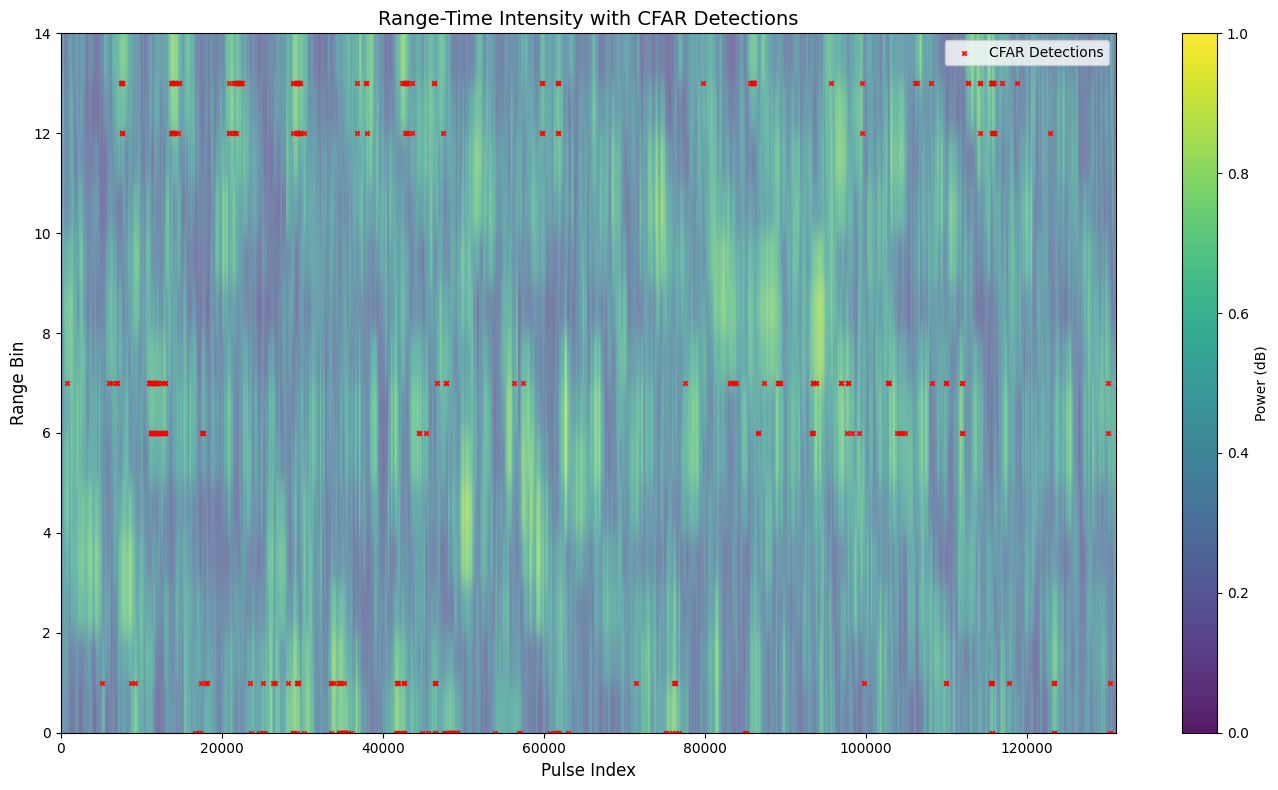

In [130]:
# Assuming you've already run CFAR and have all_detections
all_detections = process_by_cpi(A, cpi_length=256)

# Complete analysis
targets, summary, det_matrix = complete_target_analysis(A, all_detections)

# Print summary
print(f"Total detections: {summary['total_detections']}")
print(f"Number of tracks: {summary['total_tracks']}")
print(f"Detections per range bin: {summary['detections_per_range']}")
print(f"Average track length: {summary['mean_track_length']:.2f} pulses")

# Print first few targets
print("\nFirst 10 target detections:")
for i, target in enumerate(targets[:10]):
    loc = target['location']
    print(f"Target {i}: Pulse {loc['global_pulse']}, Range Bin {loc['range_bin']}, "
          f"CPI {loc['cpi_index']}")

# Visualize
plot_target_locations(det_matrix)
plot_range_time_intensity(A, det_matrix)

# # Save results
# import pandas as pd
# targets_df = pd.DataFrame([t['location'] for t in targets])
# targets_df.to_csv('cfar_detections.csv', index=False)

In [172]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist

def identify_target_classes(vectors, class_labels, n_targets=2):
    """
    Identify which classes are most different from the others.
    
    Parameters:
    - vectors: (7154, 256) array
    - class_labels: array of 0-13 for each vector
    - n_targets: how many target classes to identify (default: 2)
    """
    
    n_classes = 14
    n_vectors = len(vectors)
    
    print(f"Analyzing {n_vectors} vectors across {n_classes} classes")
    print(f"Looking for {n_targets} target class(es)")
    
    # 1. Normalize data
    scaler = StandardScaler()
    vectors_norm = scaler.fit_transform(vectors)
    
    # 2. Calculate class centroids
    centroids = []
    class_sizes = []
    
    for cls in range(n_classes):
        class_points = vectors_norm[class_labels == cls]
        centroids.append(class_points.mean(axis=0))
        class_sizes.append(len(class_points))
    
    centroids = np.array(centroids)  # shape: (14, 256)
    
    # 3. Calculate pairwise distances between centroids
    centroid_distances = cdist(centroids, centroids, metric='euclidean')
    
    # 4. For each class, calculate its average distance to other classes
    class_separability = []
    
    for i in range(n_classes):
        # Distance from class i to all other classes (excluding self)
        distances_to_others = centroid_distances[i, np.arange(n_classes) != i]
        avg_distance = distances_to_others.mean()
        
        # Also calculate compactness (within-class variance)
        class_points = vectors_norm[class_labels == i]
        distances_to_own_centroid = np.linalg.norm(class_points - centroids[i], axis=1)
        compactness = distances_to_own_centroid.std()
        
        class_separability.append({
            'class': i,
            'avg_distance_to_others': avg_distance,
            'compactness': compactness,
            'separability_score': avg_distance / np.log(compactness + 1e-10),
            'size': class_sizes[i]
        })
    
    # Convert to DataFrame
    df_sep = pd.DataFrame(class_separability)
    df_sep = df_sep.sort_values('separability_score', ascending=False)
    
    # 5. Identify target classes
    target_classes = df_sep.head(n_targets)['class'].values
    
    return df_sep, target_classes, centroids, centroid_distances

In [187]:
def visualize_class_relationships(df_sep, centroid_distances, target_classes,fig_index=0):
    """
    Create visualizations to understand class relationships.
    """
    fig = plt.figure(figsize=(16, 10))
    
    # Plot 1: Class separability scores
    ax1 = plt.subplot(2, 2, 1)
    colors = ['red' if cls in target_classes else 'blue' 
              for cls in range(len(df_sep))]
    
    bars = ax1.bar(range(len(df_sep)), df_sep['separability_score'], 
                   color=colors, alpha=0.7)
    ax1.set_xlabel('Class')
    ax1.set_ylabel('Separability Score')
    ax1.set_title('Class Separability (Higher = More Different)')
    ax1.set_xticks(range(len(df_sep)))
    ax1.set_xticklabels([f'C{c}' for c in df_sep['class']])
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Distance matrix heatmap
    ax2 = plt.subplot(2, 2, 2)
    im = ax2.imshow(centroid_distances, cmap='viridis')
    
    # Highlight target classes
    for cls in target_classes:
        ax2.add_patch(plt.Rectangle((cls-0.5, -0.5), 1, len(centroid_distances),
                                   fill=False, edgecolor='red', linewidth=2))
        ax2.add_patch(plt.Rectangle((-0.5, cls-0.5), len(centroid_distances), 1,
                                   fill=False, edgecolor='red', linewidth=2))
    
    ax2.set_xlabel('Class')
    ax2.set_ylabel('Class')
    ax2.set_title('Distance Between Class Centroids')
    plt.colorbar(im, ax=ax2, label='Euclidean Distance')
    ax2.set_xticks(range(14))
    ax2.set_yticks(range(14))
    
    # Plot 3: Compactness vs Distance to Others
    ax3 = plt.subplot(2, 2, 3)
    scatter = ax3.scatter(df_sep['compactness'], df_sep['avg_distance_to_others'],
                         c=colors, s=df_sep['size']/5, alpha=0.7)
    
    # Annotate each point with class number
    for i, row in df_sep.iterrows():
        ax3.annotate(f"C{int(row['class'])}", 
                    (row['compactness'], row['avg_distance_to_others']),
                    xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    ax3.set_xlabel('Compactness (Lower = Tighter Cluster)')
    ax3.set_ylabel('Avg Distance to Other Classes')
    ax3.set_title('Compactness vs Separation')
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Class sizes
    ax4 = plt.subplot(2, 2, 4)
    size_colors = ['red' if cls in target_classes else 'blue' 
                   for cls in df_sep['class']]
    ax4.bar(range(len(df_sep)), df_sep['size'], color=size_colors, alpha=0.7)
    ax4.set_xlabel('Class')
    ax4.set_ylabel('Number of Vectors')
    ax4.set_title('Class Sizes')
    ax4.set_xticks(range(len(df_sep)))
    ax4.set_xticklabels([f'C{c}' for c in df_sep['class']])
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Print summary
    print("\n" + "="*60)
    print("TARGET CLASS IDENTIFICATION RESULTS")
    print("="*60)
    print(f"\nIdentified Target Classes: {sorted(target_classes)}")
    print("\nTop candidates (ordered by separability):")
    for i, row in df_sep.iterrows():
        marker = "★" if row['class'] in target_classes else " "
        print(f"{marker} Class {int(row['class']):2d}: "
              f"SepScore={row['separability_score']:.3f}, "
              f"AvgDist={row['avg_distance_to_others']:.3f}, "
              f"Compact={row['compactness']:.3f}, "
              f"Size={row['size']}")
    plt.savefig(f"results/{fig_index}.png")
    return fig

In [188]:
def verify_with_umap(vectors, class_labels, target_classes):
    """
    Use UMAP to visualize and verify target class identification.
    """
    scaler = StandardScaler()
    vectors_norm = scaler.fit_transform(vectors)
    
    # Run UMAP with all classes
    import umap
    reducer = umap.UMAP(
        n_components=2,
        n_neighbors=30,
        min_dist=0.1,
        metric='euclidean',
        random_state=42,
        n_epochs=1000
    )
    
    embedding = reducer.fit_transform(vectors_norm)
    
    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    # Plot 1: All classes with distinct colors
    colors_all = plt.cm.tab20(np.linspace(0, 1, 14))
    
    for cls in range(14):
        mask = class_labels == cls
        color = colors_all[cls]
        axes[0].scatter(
            embedding[mask, 0], embedding[mask, 1],
            color=color, s=10, alpha=0.6,
            label=f'Class {cls}' if cls < 8 else ''
        )
    
    axes[0].set_title('All 14 Classes (Distinct Colors)')
    axes[0].set_xlabel('UMAP 1')
    axes[0].set_ylabel('UMAP 2')
    axes[0].legend(loc='upper left', fontsize=8)
    axes[0].grid(alpha=0.2)
    
    # Plot 2: Target vs Non-target (binary)
    target_mask = np.isin(class_labels, target_classes)
    
    axes[1].scatter(
        embedding[~target_mask, 0], embedding[~target_mask, 1],
        c='blue', s=10, alpha=0.3, label='Non-target (12 classes)'
    )
    axes[1].scatter(
        embedding[target_mask, 0], embedding[target_mask, 1],
        c='red', s=30, alpha=0.8, label=f'Target classes {target_classes.tolist()}'
    )
    
    axes[1].set_title(f'Target Classes vs Others')
    axes[1].set_xlabel('UMAP 1')
    axes[1].set_ylabel('UMAP 2')
    axes[1].legend()
    axes[1].grid(alpha=0.2)
    
    plt.tight_layout()
    
    # Calculate separation metrics
    from sklearn.metrics import silhouette_score
    binary_labels = np.isin(class_labels, target_classes).astype(int)
    sil_score = silhouette_score(embedding, binary_labels)
    
    print(f"\nUMAP Verification:")
    print(f"Silhouette score (targets vs others): {sil_score:.4f}")
    if sil_score > 0.5:
        print("  → Good separation! Targets are distinct.")
    elif sil_score > 0.25:
        print("  → Moderate separation.")
    else:
        print("  → Poor separation. Targets may not be visually distinct.")
    
    return embedding, sil_score

In [189]:
from scipy import stats
from sklearn.feature_selection import f_classif

def statistical_class_analysis(vectors, class_labels, target_classes):
    """
    Perform statistical tests to verify class differences.
    """
    # Convert to binary: targets vs non-targets
    binary_labels = np.isin(class_labels, target_classes).astype(int)
    
    # ANOVA F-test for each feature
    f_values, p_values = f_classif(vectors, binary_labels)
    
    # Find most discriminative features
    top_features = np.argsort(f_values)[-10:][::-1]
    
    print("\n" + "="*60)
    print("STATISTICAL ANALYSIS")
    print("="*60)
    print(f"\nTop 10 most discriminative features (targets vs others):")
    for i, feat in enumerate(top_features):
        print(f"  {i+1:2d}. Feature {feat:3d}: F={f_values[feat]:8.2f}, "
              f"p={p_values[feat]:.2e}")
    
    # Plot distributions of top features
    fig, axes = plt.subplots(2, 5, figsize=(16, 8))
    axes = axes.flatten()
    
    for ax, feat in zip(axes, top_features):
        # Get values for targets and non-targets
        target_vals = vectors[binary_labels == 1, feat]
        nontarget_vals = vectors[binary_labels == 0, feat]
        
        # Plot histograms
        ax.hist(nontarget_vals, bins=30, alpha=0.5, color='blue', 
                density=True, label='Non-target')
        ax.hist(target_vals, bins=30, alpha=0.7, color='red',
                density=True, label='Target')
        
        # Add mean lines
        ax.axvline(nontarget_vals.mean(), color='blue', linestyle='--', alpha=0.7)
        ax.axvline(target_vals.mean(), color='red', linestyle='--', alpha=0.7)
        
        ax.set_title(f'Feature {feat}\nF={f_values[feat]:.1f}')
        ax.set_xlabel('Value')
        ax.set_ylabel('Density')
        if feat == top_features[0]:
            ax.legend()
    
    plt.suptitle(f'Feature Distributions: Target Classes {target_classes} vs Others', 
                 fontsize=14)
    plt.tight_layout()
    
    # Perform t-test on feature means
    print(f"\nT-tests for feature means (targets vs non-targets):")
    significant_features = []
    for feat in top_features[:5]:  # Just show top 5
        target_vals = vectors[binary_labels == 1, feat]
        nontarget_vals = vectors[binary_labels == 0, feat]
        
        t_stat, p_val = stats.ttest_ind(target_vals, nontarget_vals, 
                                        equal_var=False)
        significant = p_val < 0.05
        if significant:
            significant_features.append(feat)
        
        print(f"  Feature {feat:3d}: t={t_stat:7.3f}, p={p_val:.3e} "
              f"{'**' if p_val < 0.01 else '*' if p_val < 0.05 else ' '}")
    
    return top_features, significant_features

TARGET CLASS IDENTIFICATION PIPELINE

Step 1: Analyzing class separability...
Analyzing 7154 vectors across 14 classes
Looking for 2 target class(es)

Step 2: Visualizing class relationships...

TARGET CLASS IDENTIFICATION RESULTS

Identified Target Classes: [6, 8]

Top candidates (ordered by separability):
★ Class  8: SepScore=2.810, AvgDist=4.670, Compact=5.270, Size=511.0
★ Class  6: SepScore=2.459, AvgDist=5.786, Compact=10.515, Size=511.0
  Class  1: SepScore=2.214, AvgDist=3.791, Compact=5.542, Size=511.0
  Class 12: SepScore=2.054, AvgDist=3.568, Compact=5.680, Size=511.0
  Class  4: SepScore=2.040, AvgDist=5.461, Compact=14.550, Size=511.0
  Class  3: SepScore=2.014, AvgDist=4.927, Compact=11.549, Size=511.0
  Class 13: SepScore=1.990, AvgDist=3.497, Compact=5.801, Size=511.0
  Class  7: SepScore=1.952, AvgDist=4.252, Compact=8.830, Size=511.0
  Class  5: SepScore=1.901, AvgDist=4.780, Compact=12.364, Size=511.0
  Class  0: SepScore=1.860, AvgDist=3.400, Compact=6.224, Size=511

/home/shu/.conda/envs/IG/lib/python3.14/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



UMAP Verification:
Silhouette score (targets vs others): 0.0382
  → Poor separation. Targets may not be visually distinct.

Step 4: Performing statistical tests...

STATISTICAL ANALYSIS

Top 10 most discriminative features (targets vs others):
   1. Feature   2: F=  185.64, p=9.40e-42
   2. Feature   1: F=  183.37, p=2.86e-41
   3. Feature   0: F=  179.79, p=1.65e-40
   4. Feature   3: F=  178.63, p=2.93e-40
   5. Feature 255: F=  177.27, p=5.70e-40
   6. Feature 254: F=  172.96, p=4.72e-39
   7. Feature   4: F=  168.55, p=4.13e-38
   8. Feature 253: F=  162.27, p=9.04e-37
   9. Feature   5: F=  152.29, p=1.23e-34
  10. Feature 252: F=  149.92, p=3.96e-34

T-tests for feature means (targets vs non-targets):
  Feature   2: t= 12.659, p=9.780e-35 **
  Feature   1: t= 12.538, p=3.889e-34 **
  Feature   0: t= 12.378, p=2.339e-33 **
  Feature   3: t= 12.483, p=7.058e-34 **
  Feature 255: t= 12.362, p=2.753e-33 **

Step 5: Cross-checking with alternative metrics...

Cosine-based target clas

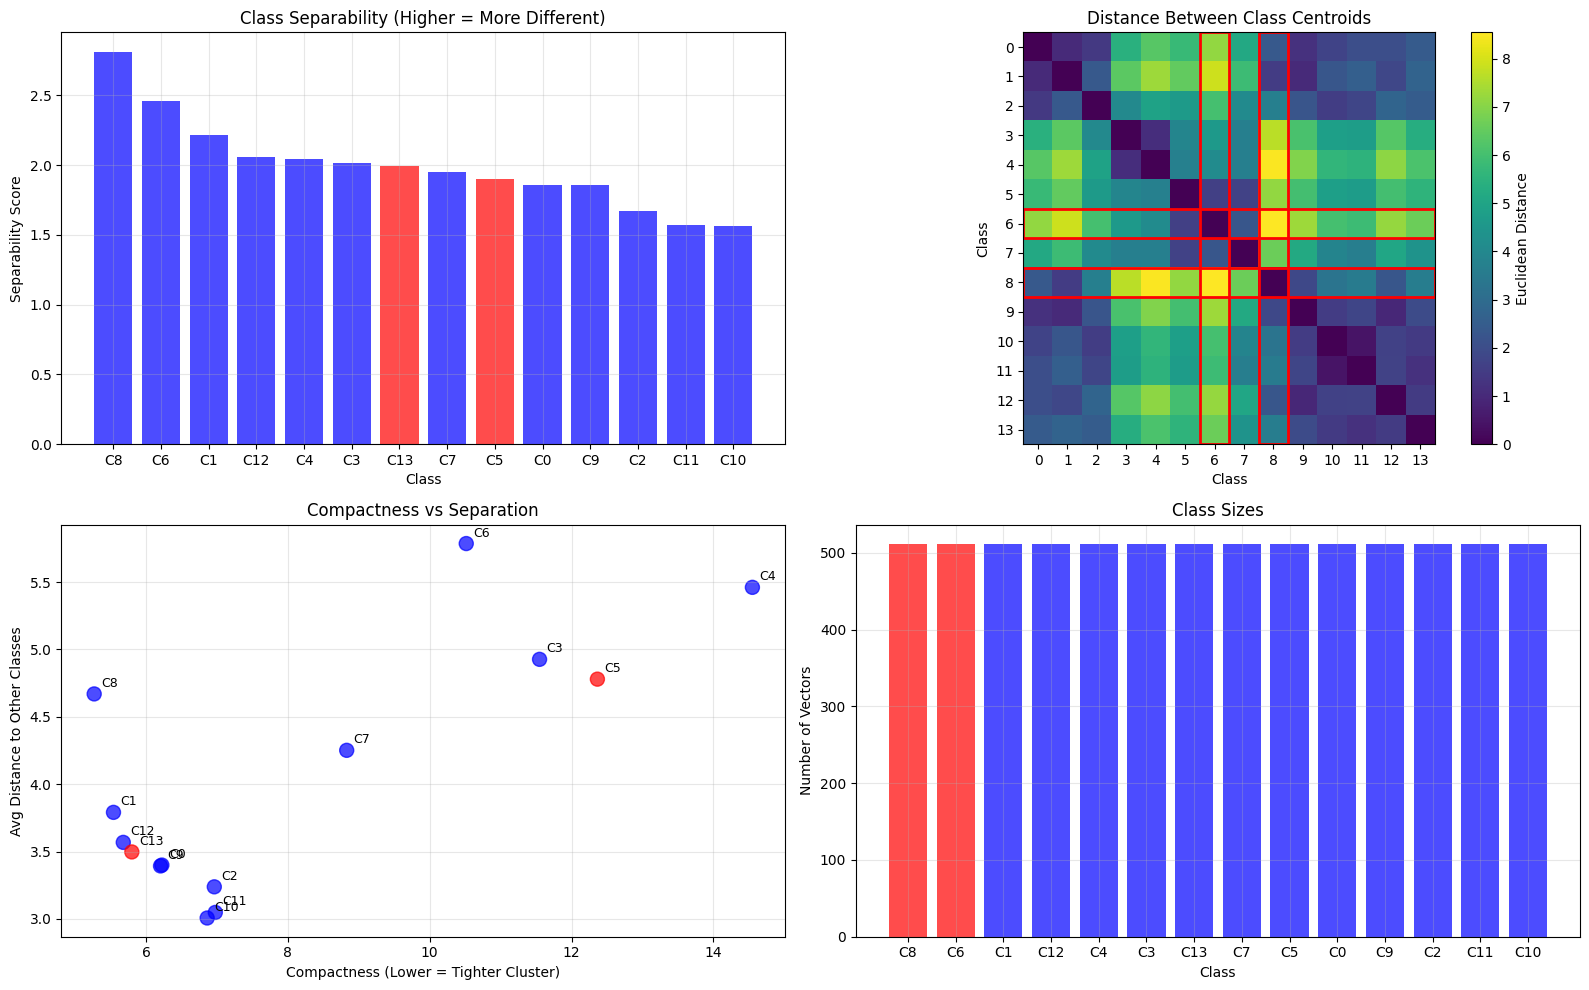

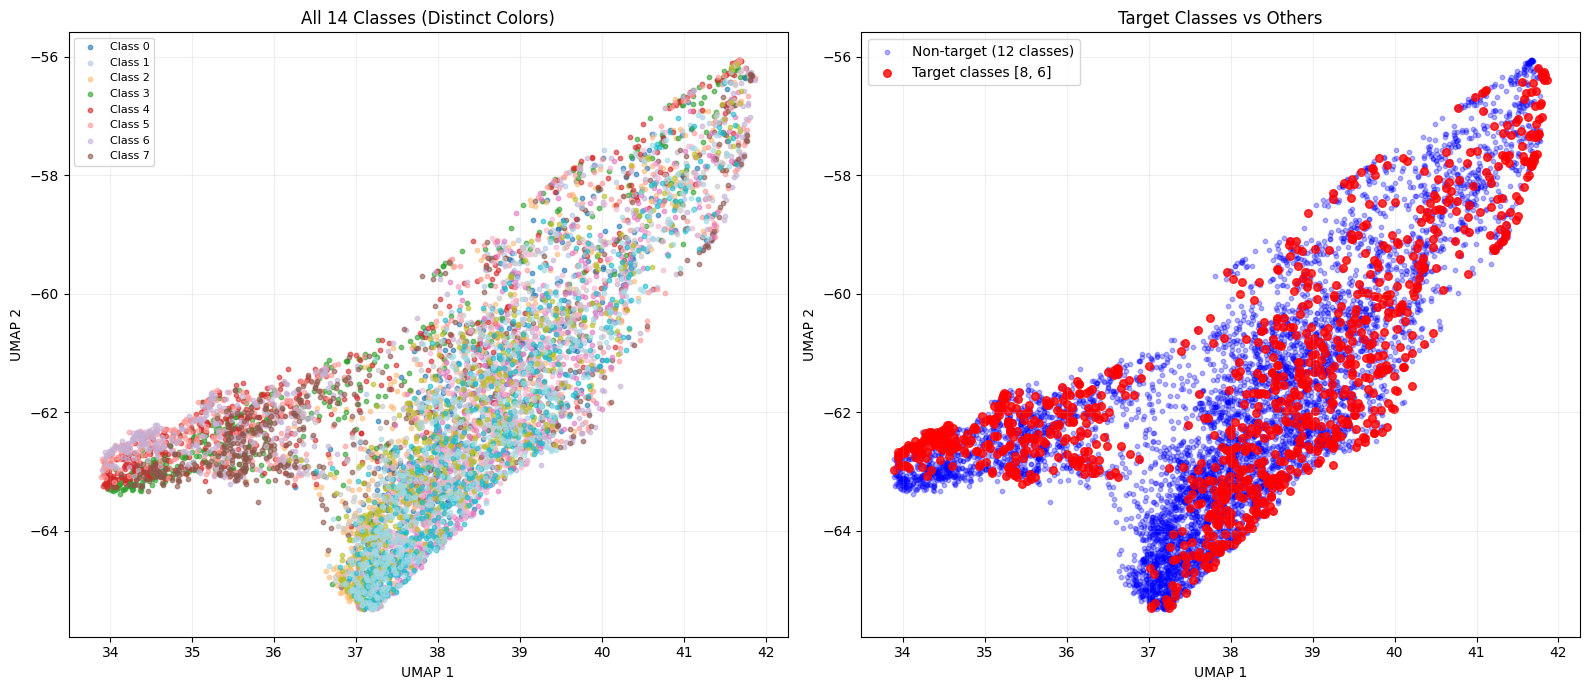

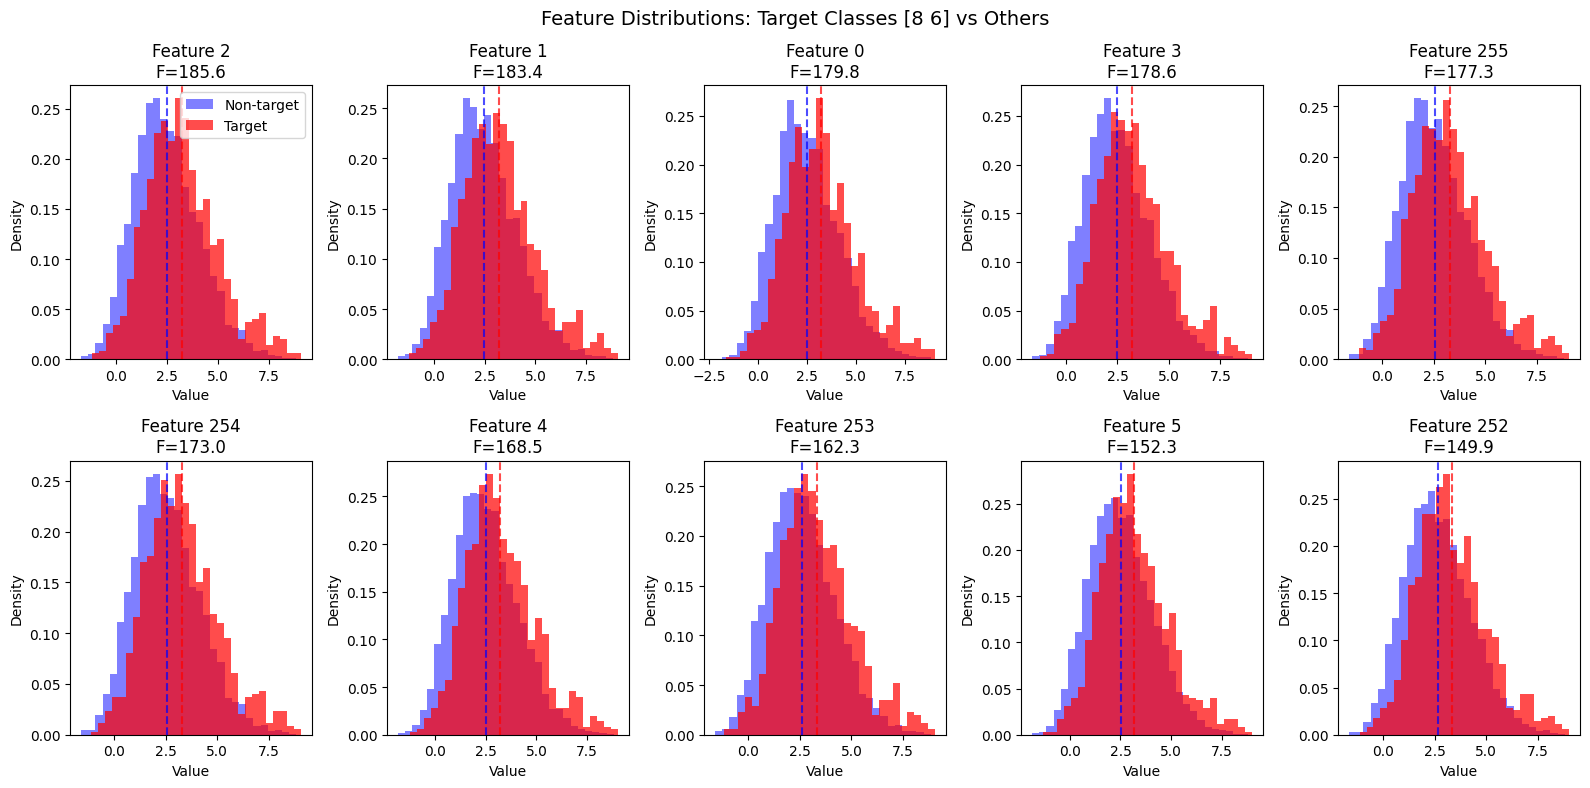

In [191]:
def identify_targets_complete(vectors, class_labels, n_targets=2,index=0):
    """
    Complete pipeline to identify target classes.
    """
    print("="*70)
    print("TARGET CLASS IDENTIFICATION PIPELINE")
    print("="*70)
    
    # Step 1: Calculate class separability
    print("\nStep 1: Analyzing class separability...")
    df_sep, target_classes, centroids, centroid_distances = \
        identify_target_classes(vectors, class_labels, n_targets)
    
    # Step 2: Visualize class relationships
    print("\nStep 2: Visualizing class relationships...")
    fig1 = visualize_class_relationships(df_sep, centroid_distances, target_classes,index)
    
    # Step 3: Verify with UMAP
    print("\nStep 3: Verifying with UMAP visualization...")
    embedding, sil_score = verify_with_umap(vectors, class_labels, target_classes)
    
    # Step 4: Statistical analysis
    print("\nStep 4: Performing statistical tests...")
    top_features, significant_features = statistical_class_analysis(
        vectors, class_labels, target_classes
    )
    
    # Step 5: Cross-check with different metrics
    print("\nStep 5: Cross-checking with alternative metrics...")
    
    # Try cosine distance as alternative
    from sklearn.metrics.pairwise import cosine_distances
    cosine_dist = cosine_distances(centroids)
    
    # Calculate cosine-based separability
    cosine_separability = []
    for i in range(14):
        distances = cosine_dist[i, np.arange(14) != i]
        cosine_separability.append(distances.mean())
    
    # Add to results
    df_sep['cosine_separability'] = cosine_separability
    df_cosine_sorted = df_sep.sort_values('cosine_separability', ascending=False)
    cosine_targets = df_cosine_sorted.head(n_targets)['class'].values
    
    print(f"\nCosine-based target classes: {sorted(cosine_targets)}")
    if set(target_classes) == set(cosine_targets):
        print("✓ Consistent with Euclidean distance results")
    else:
        print(f"⚠ Different from Euclidean results: {sorted(target_classes)}")
        print("   Consider both sets of candidates")
    
    # Compile final results
    results = {
        'target_classes': target_classes,
        'candidate_classes': cosine_targets,
        'separability_df': df_sep,
        'silhouette_score': sil_score,
        'top_features': top_features,
        'significant_features': significant_features,
        'centroids': centroids,
        'embedding': embedding
    }
    
    # Final recommendation
    print("\n" + "="*70)
    print("FINAL RECOMMENDATION")
    print("="*70)
    
    if sil_score > 0.3:
        print(f"✅ STRONG CANDIDATES: Classes {sorted(target_classes)}")
        print(f"   These classes are visually distinct from others.")
    elif sil_score > 0.15:
        print(f"⚠ MODERATE CANDIDATES: Classes {sorted(target_classes)}")
        print(f"   These classes show some separation but may overlap.")
    else:
        print(f"❓ WEAK CANDIDATES: Classes {sorted(target_classes)}")
        print(f"   Poor separation. Consider manual inspection.")
    
    if len(significant_features) > 5:
        print(f"✓ Good statistical significance ({len(significant_features)} significant features)")
    
    return results

# Run the complete analysis
labels = np.arange(conc.shape[0]) % 14
results = identify_targets_complete(conc, labels, n_targets=2)

TARGET CLASS IDENTIFICATION PIPELINE

Step 1: Analyzing class separability...
Analyzing 7154 vectors across 14 classes
Looking for 2 target class(es)

Step 2: Visualizing class relationships...

TARGET CLASS IDENTIFICATION RESULTS

Identified Target Classes: [6, 8]

Top candidates (ordered by separability):
★ Class  8: SepScore=2.810, AvgDist=4.670, Compact=5.270, Size=511.0
★ Class  6: SepScore=2.459, AvgDist=5.786, Compact=10.515, Size=511.0
  Class  1: SepScore=2.214, AvgDist=3.791, Compact=5.542, Size=511.0
  Class 12: SepScore=2.054, AvgDist=3.568, Compact=5.680, Size=511.0
  Class  4: SepScore=2.040, AvgDist=5.461, Compact=14.550, Size=511.0
  Class  3: SepScore=2.014, AvgDist=4.927, Compact=11.549, Size=511.0
  Class 13: SepScore=1.990, AvgDist=3.497, Compact=5.801, Size=511.0
  Class  7: SepScore=1.952, AvgDist=4.252, Compact=8.830, Size=511.0
  Class  5: SepScore=1.901, AvgDist=4.780, Compact=12.364, Size=511.0
  Class  0: SepScore=1.860, AvgDist=3.400, Compact=6.224, Size=511

/home/shu/.conda/envs/IG/lib/python3.14/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



UMAP Verification:
Silhouette score (targets vs others): 0.0382
  → Poor separation. Targets may not be visually distinct.

Step 4: Performing statistical tests...

STATISTICAL ANALYSIS

Top 10 most discriminative features (targets vs others):
   1. Feature   2: F=  185.64, p=9.40e-42
   2. Feature   1: F=  183.37, p=2.86e-41
   3. Feature   0: F=  179.79, p=1.65e-40
   4. Feature   3: F=  178.63, p=2.93e-40
   5. Feature 255: F=  177.27, p=5.70e-40
   6. Feature 254: F=  172.96, p=4.72e-39
   7. Feature   4: F=  168.55, p=4.13e-38
   8. Feature 253: F=  162.27, p=9.04e-37
   9. Feature   5: F=  152.29, p=1.23e-34
  10. Feature 252: F=  149.92, p=3.96e-34

T-tests for feature means (targets vs non-targets):
  Feature   2: t= 12.659, p=9.780e-35 **
  Feature   1: t= 12.538, p=3.889e-34 **
  Feature   0: t= 12.378, p=2.339e-33 **
  Feature   3: t= 12.483, p=7.058e-34 **
  Feature 255: t= 12.362, p=2.753e-33 **

Step 5: Cross-checking with alternative metrics...

Cosine-based target clas

/home/shu/.conda/envs/IG/lib/python3.14/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


KeyboardInterrupt: 

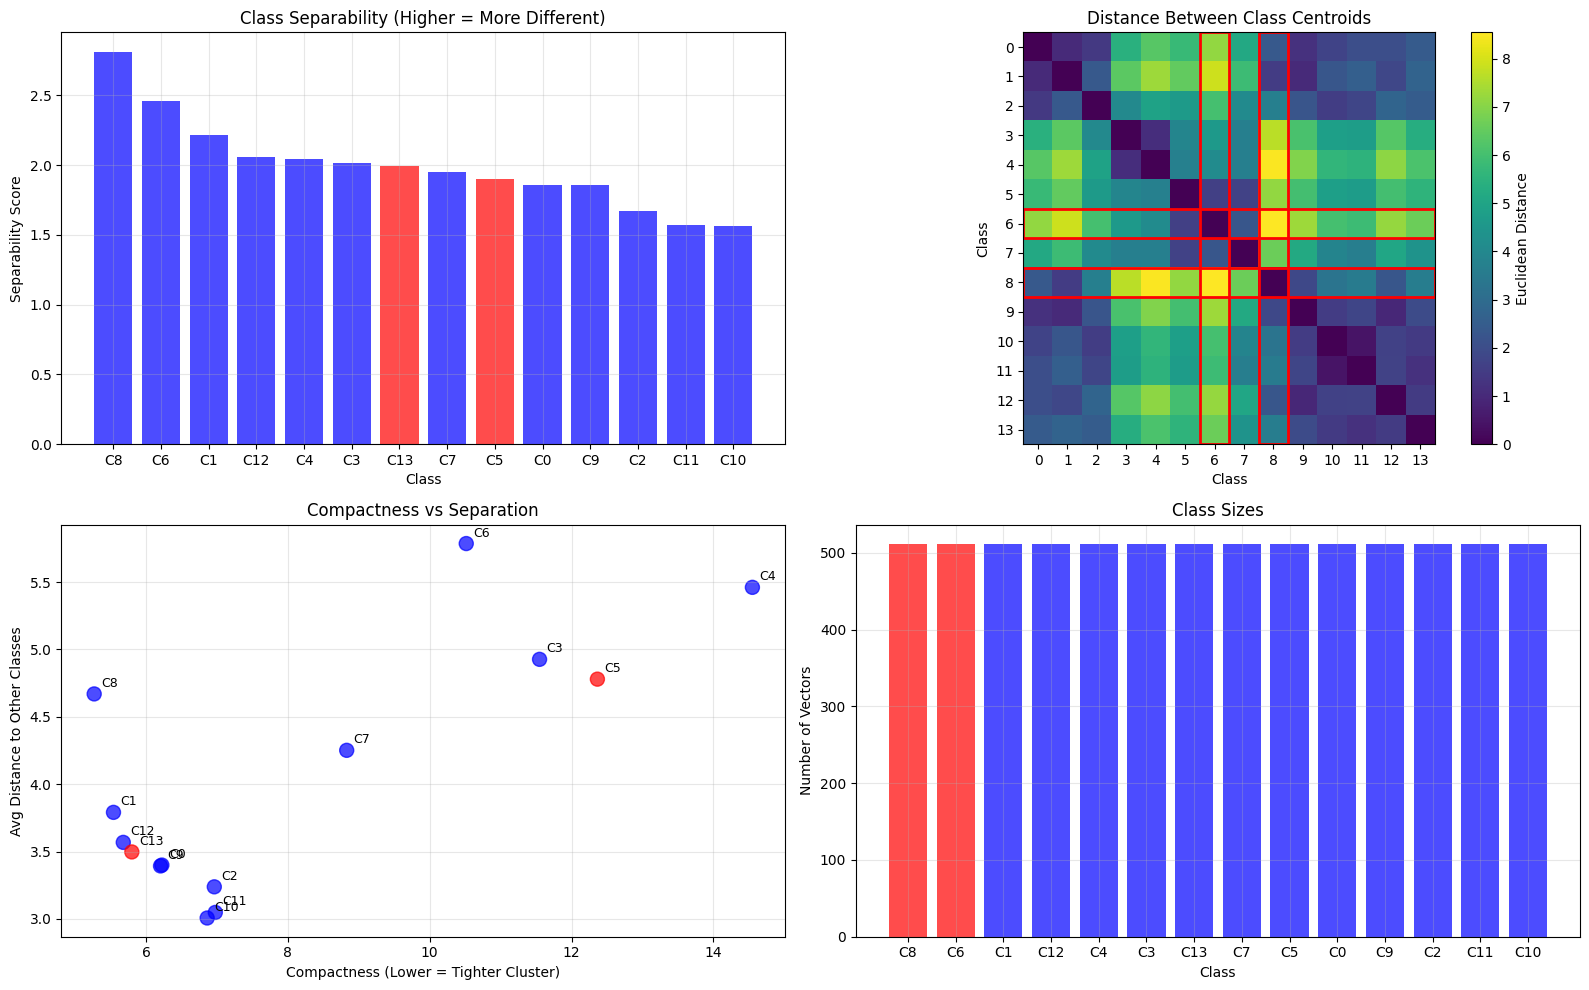

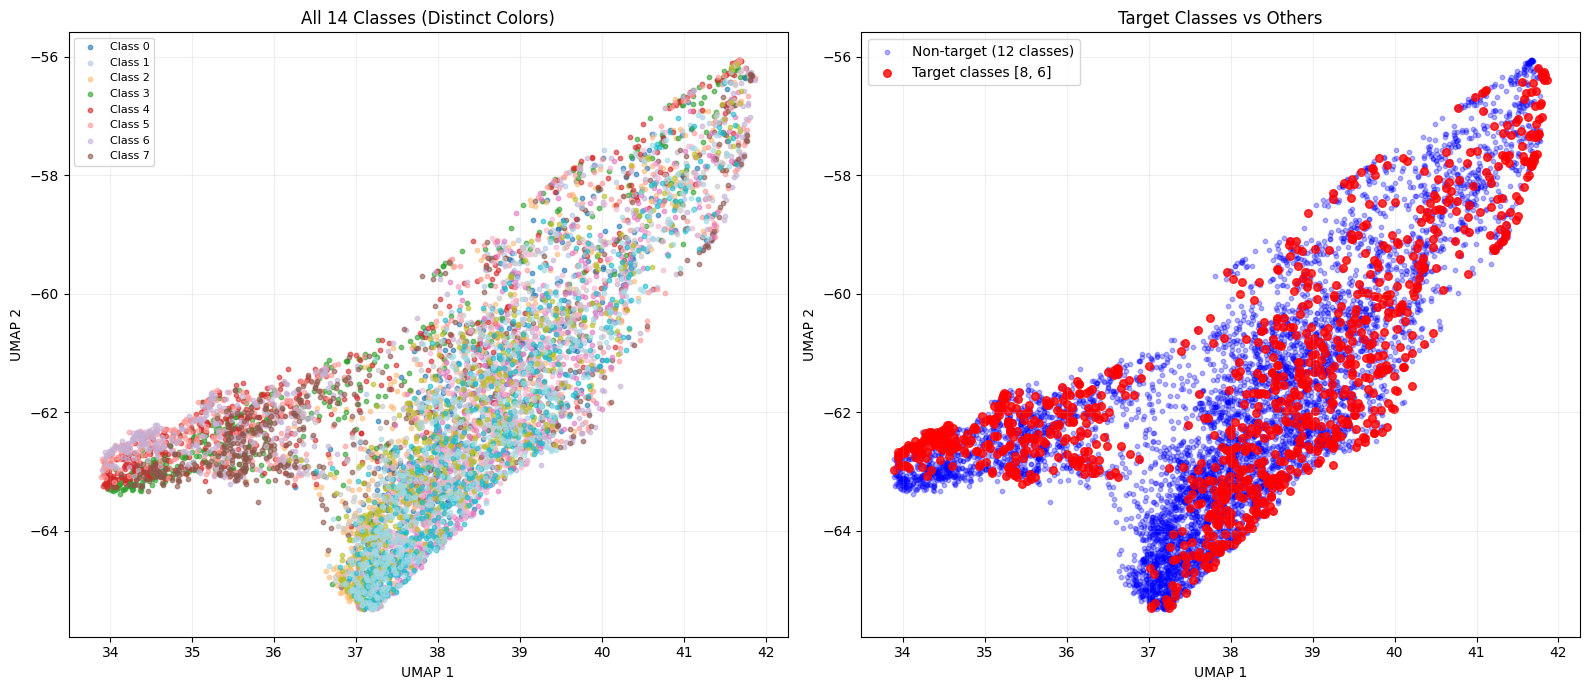

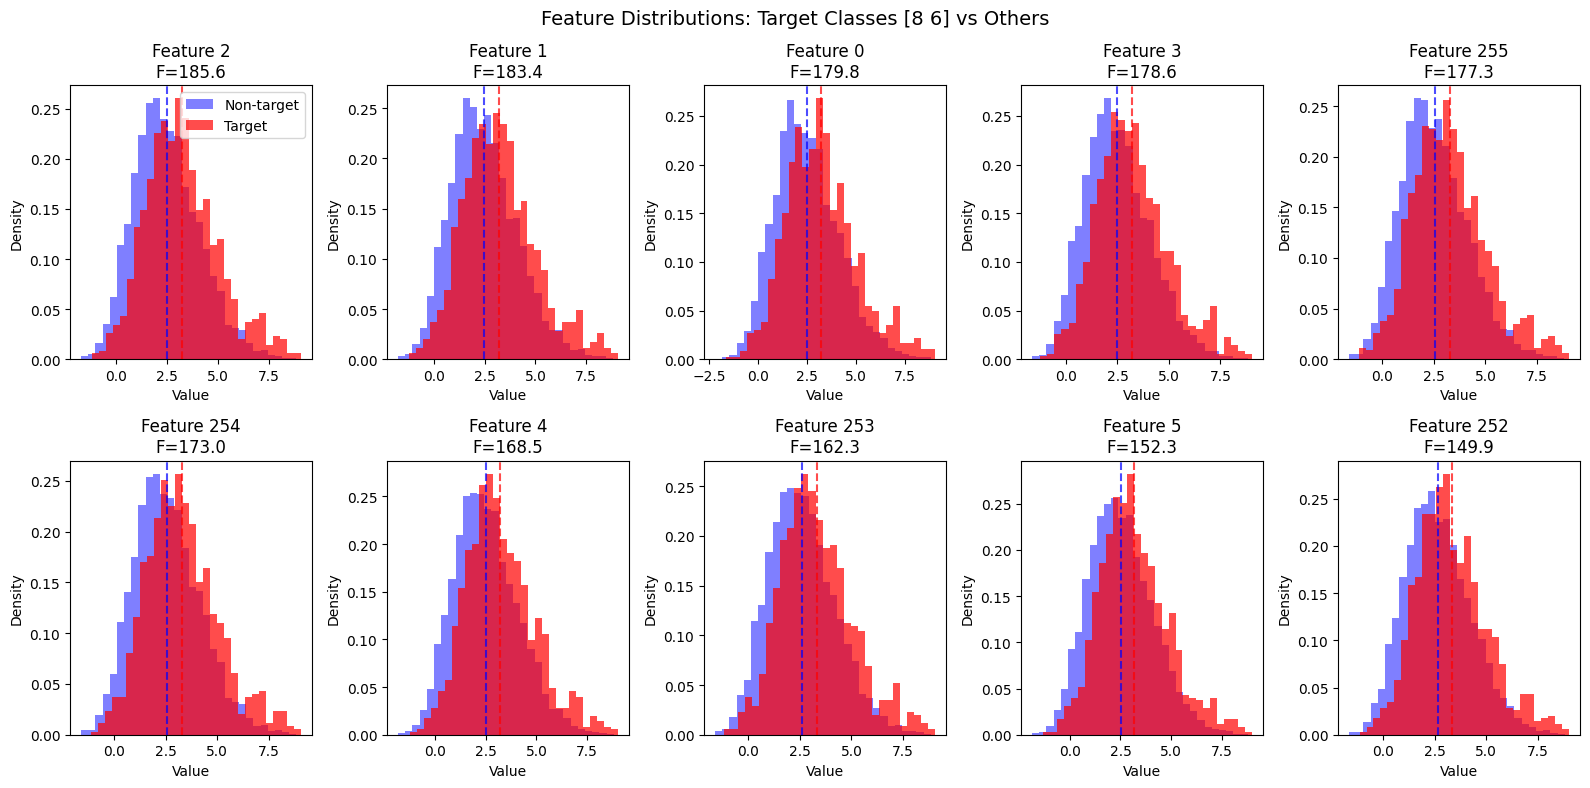

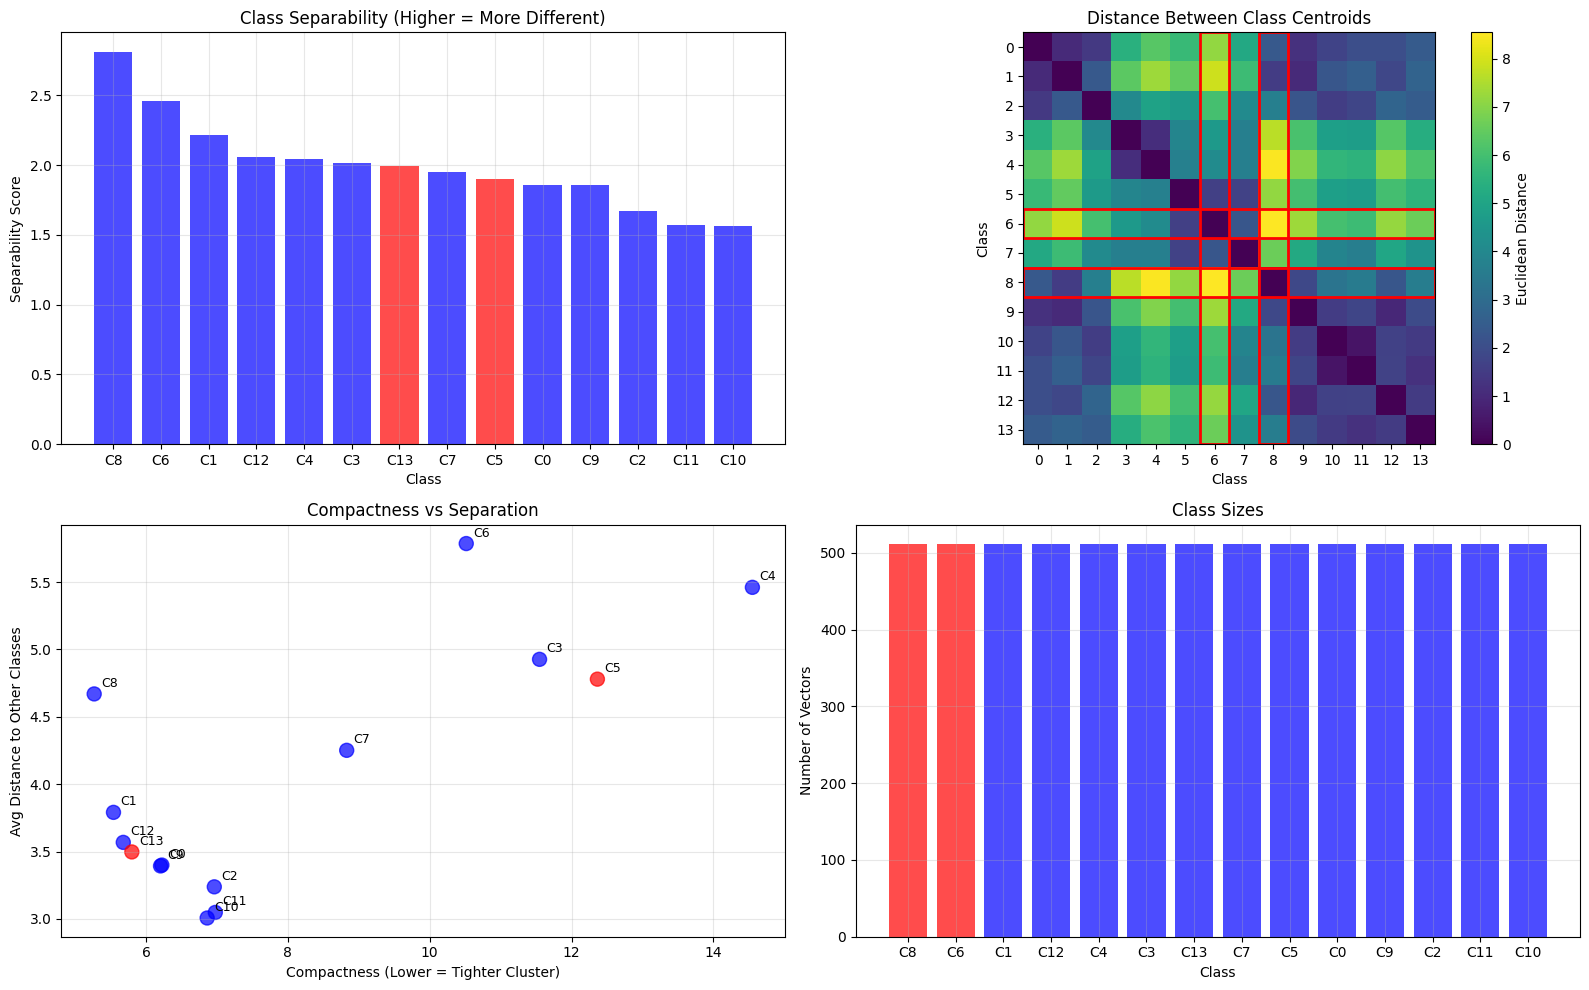

In [192]:
def pipeline(file_index):
    A=load_data(31)
    conc=coherent(A)
    labels = np.arange(conc.shape[0]) % 14
    results = identify_targets_complete(conc, labels, n_targets=2, index=file_index)
    return results
for file_index in [17,18,19,25,26,30,31,40,54,280,283,310,311,320]:
    pipeline(file_index)